In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader,Dataset
from torchvision.utils import make_grid
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from collections import defaultdict
from sklearn.metrics import f1_score,accuracy_score

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Ensure images are converted to tensors
])

In [4]:
dataset = datasets.ImageFolder(root=r"C:\Users\mushfika_rahman1\Documents\Research\research-summer-2024\LIMUC\train_and_validation_sets",transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

subset_dir = r"C:\Users\mushfika_rahman1\Documents\Research\research-summer-2024\LIMUC\subset"
os.makedirs(subset_dir, exist_ok=True)

In [5]:
samples_per_class = 10

collected_samples = {}
for class_name in dataset.classes:
    collected_samples[class_name] = 0

print(collected_samples)

{'Mayo 0': 0, 'Mayo 1': 0, 'Mayo 2': 0, 'Mayo 3': 0}


In [6]:
for batch_images, batch_labels in dataloader:
    for i in range(len(batch_images)):
    # Get each image and label from the batch
        image = batch_images[i]       # Image tensor at index i
        label = batch_labels[i]       # Label tensor at index i    
    # Convert the label tensor to a Python integer using .item()
        label_value = label.item()    # Convert to a scalar integer
    
    # Use the label to get the corresponding class name from dataset.classes
        class_name = dataset.classes[label_value]
        
    if collected_samples[class_name] < samples_per_class:
            # Define the path to save the image
            class_dir = os.path.join(subset_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)

            # Save the image
            image_path = os.path.join(class_dir, f'{class_name}_{collected_samples[class_name]}.jpg')
            # Convert tensor back to PIL image
            image_pil = transforms.ToPILImage()(image)
            image_pil.save(image_path)

            # Update the count for this class
            collected_samples[class_name] += 1
    if all(count >= samples_per_class for count in collected_samples.values()):
        break

print(f"Subset created at {subset_dir}")

Subset created at C:\Users\mushfika_rahman1\Documents\Research\research-summer-2024\LIMUC\subset


In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    # Ensure images are converted to tensors
])

In [41]:
subset_dataset = datasets.ImageFolder(root=r"C:\Users\mushfika_rahman1\Documents\Research\research-summer-2024\LIMUC\subset",transform=transform)
subset_loader = DataLoader(subset_dataset, batch_size=16, shuffle=True)

In [12]:
for batch_images, batch_labels in subset_loader:
    # Print the type of batch_images and batch_labels
    print(f"Type of batch_images: {type(batch_images)}")
    print(f"Type of batch_labels: {type(batch_labels)}")

    # Print the shape of batch_images to get the batch size and image dimensions
    print(f"Batch image tensor size: {batch_images.size()}")  # Should print [batch_size, channels, height, width]
    print(f"Batch labels: {batch_labels}")

    # Optionally, print the batch size only
    batch_size = batch_images.size(0)
    print(f"Batch size: {batch_size}")
    
    # Optionally, you can also check if the elements in the batch are tensors
    if isinstance(batch_images, torch.Tensor):
        print("Batch images are tensors.")
    else:
        print("Batch images are not tensors.")
    
    # You only need to check the first batch to confirm
    break

Type of batch_images: <class 'torch.Tensor'>
Type of batch_labels: <class 'torch.Tensor'>
Batch image tensor size: torch.Size([8, 3, 224, 224])
Batch labels: tensor([3, 0, 0, 1, 2, 3, 2, 2])
Batch size: 8
Batch images are tensors.


In [14]:
def rotate_image(x):
    angles = [0, 90, 180, 270]
    rotated_images=[]
    rotated_labels=[]
    for angle in angles:
        rotated_img = TF.rotate(x,angle)
        rotated_images.append(rotated_img)
        rotated_labels.append(angles.index(angle))
        #rotated_labels.append(angle)
    return rotated_images,rotated_labels

In [13]:
class CustomRotatedDataset(Dataset):
    def __init__(self, original_dataset):
        self.dataset = original_dataset

    def __len__(self):
        return len(self.dataset)*4

    def __getitem__(self, index):
        original_index = index // 4 
        angle_index = index % 4 
        
        img, _ = self.dataset[original_index]
        rotated_img, rotated_labels = rotate_image(img)
        return rotated_img[angle_index], rotated_labels[angle_index]

In [19]:
rotated_dataset = CustomRotatedDataset(subset_dataset)
rotated_loader = DataLoader(rotated_dataset, batch_size=32,shuffle=False)

In [22]:
rotation_tracker = {}

for i, (images, labels) in enumerate(rotated_loader):
    for j in range(images.size(0)):  # Loop through the batch
        original_index = (i * rotated_loader.batch_size + j) // 4
        if original_index not in rotation_tracker:
            rotation_tracker[original_index] = []
        rotation_tracker[original_index].append(labels[j].item())
    
    # Print the information for the first few images
    if i < 5:  # Change this number to inspect more images
        print(f"Batch {i+1} labels (angles): {labels.tolist()}")

# Check the rotation counts
for img_index, rotations in rotation_tracker.items():
    print(f"Image index {img_index} has rotations: {rotations}")
    if len(rotations) != 4:
        print(f"Warning: Image index {img_index} does not have 4 rotations.")

Batch 1 labels (angles): [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
Batch 2 labels (angles): [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
Batch 3 labels (angles): [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
Batch 4 labels (angles): [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
Batch 5 labels (angles): [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]
Image index 0 has rotations: [0, 1, 2, 3]
Image index 1 has rotations: [0, 1, 2, 3]
Image index 2 has rotations: [0, 1, 2, 3]
Image index 3 has rotations: [0, 1, 2, 3]
Image index 4 has rotations: [0, 1, 2, 3]
Image index 5 has rotations: [0, 1, 2, 3]
Image index 6 has rotations: [0, 1, 2, 3]
Image index 7 has rotations: [0, 1, 2, 3]
Image index 8 has rotations: [0, 1, 2, 3]
Image index 

In [30]:
def show_rotated_images(images, labels):
    """Visualizes a batch of images with their rotation angles."""
    plt.figure(figsize=(15, 15))  # Adjust the figure size as needed
    num_images = min(len(images), 20)  # Limit to 20 images

    angle_map = {0: "0°", 1: "90°", 2: "180°", 3: "270°"}
    for i in range(num_images):
        ax = plt.subplot(5, 4, i + 1)  # 5x4 grid for up to 20 images
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to HWC format for visualization
        img = (img * 0.5) + 0.5  # Unnormalize the image
        plt.imshow(img)
        plt.title(f"Angle: {angle_map[labels[i].item()]}")
        plt.axis("off")
    plt.show()

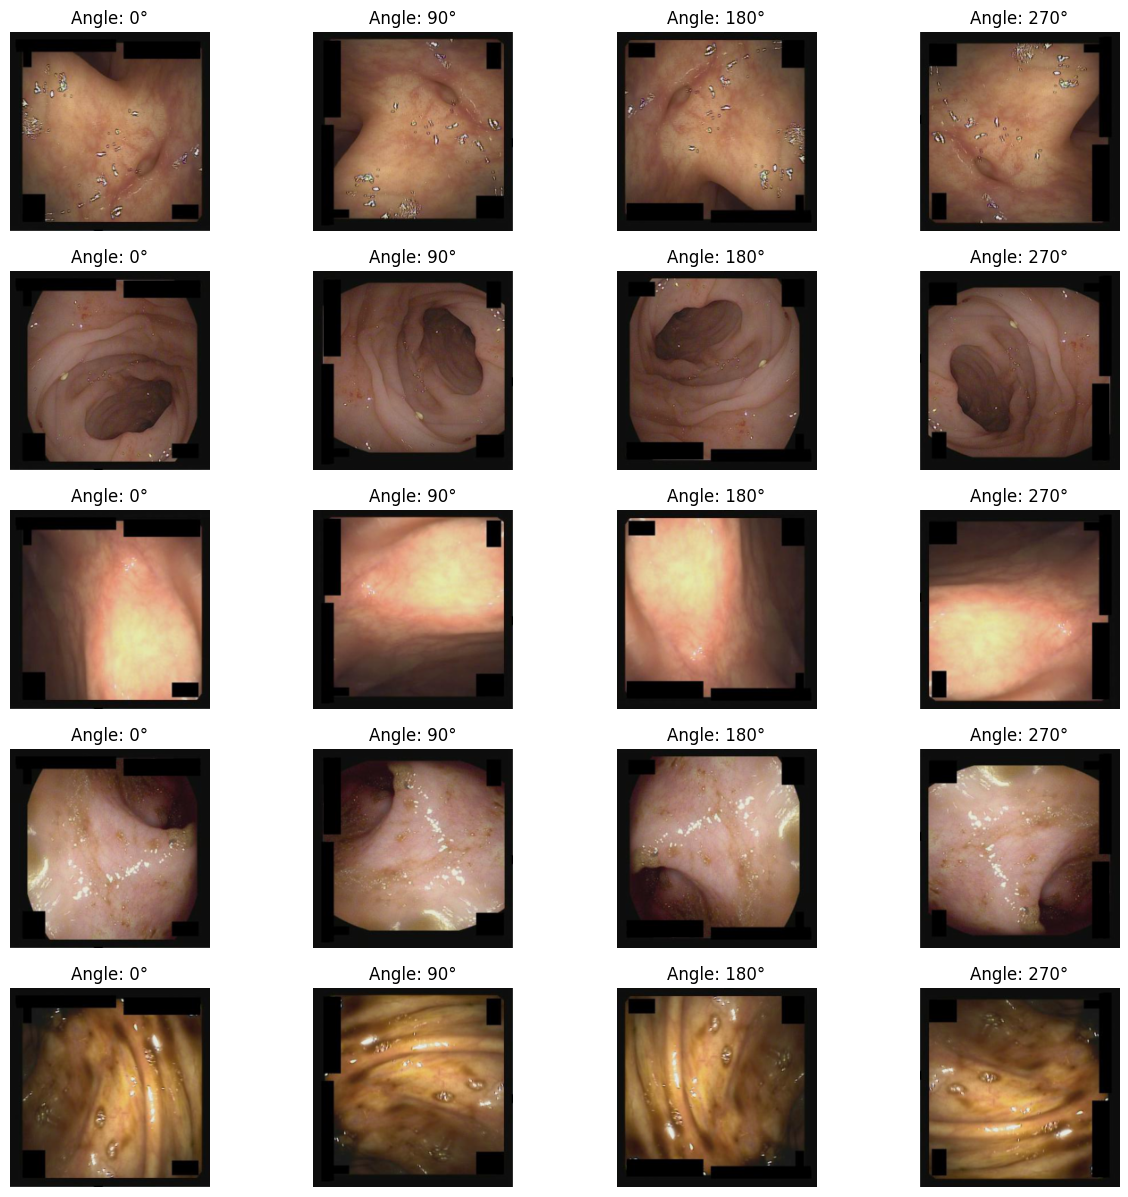

In [31]:
for images, labels in rotated_loader:
    # Visualize the images with rotation angles as labels
    show_rotated_images(images, labels)
    break  # Only visualize the first batch

In [32]:
def simple_cnn():
    model = nn.Sequential(
        nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        
        nn.Flatten(),
        nn.Linear(32 * 56 * 56, 128),  
        nn.ReLU(),
        
        nn.Linear(128, 4)  # 4 output classes (0°, 90°, 180°, 270°)
    )
    return model

In [33]:
model = simple_cnn()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Set the model to training mode
    
    for images, labels in rotated_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(rotated_loader):.4f}')

print("Finished Training")

Epoch [1/10], Loss: 2.7565
Epoch [2/10], Loss: 1.2552
Epoch [3/10], Loss: 0.5935
Epoch [4/10], Loss: 0.1471
Epoch [5/10], Loss: 0.0222
Epoch [6/10], Loss: 0.0043
Epoch [7/10], Loss: 0.0012
Epoch [8/10], Loss: 0.0003
Epoch [9/10], Loss: 0.0002
Epoch [10/10], Loss: 0.0001
Finished Training


In [35]:
torch.save(model.state_dict(), 'cnn_rotated_pretrained.pth')
print("Model weights saved.")

Model weights saved.


In [36]:
model = simple_cnn()

# Load the pre-trained weights
model.load_state_dict(torch.load('cnn_rotated_pretrained.pth'))
print("Pre-trained model weights loaded.")

Pre-trained model weights loaded.


In [42]:
num_epochs = 20
for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()  # Ensure the model is in training mode
    
    for images, labels in subset_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(subset_loader):.4f}')

print("Finished Fine-tuning on Original Dataset")

Epoch [1/20], Loss: 11.7325
Epoch [2/20], Loss: 11.2187
Epoch [3/20], Loss: 12.0877
Epoch [4/20], Loss: 11.4199
Epoch [5/20], Loss: 11.4692
Epoch [6/20], Loss: 11.8810
Epoch [7/20], Loss: 11.9476
Epoch [8/20], Loss: 11.5598
Epoch [9/20], Loss: 11.7943
Epoch [10/20], Loss: 11.2428
Epoch [11/20], Loss: 11.9264
Epoch [12/20], Loss: 11.3025
Epoch [13/20], Loss: 11.6157
Epoch [14/20], Loss: 11.3139
Epoch [15/20], Loss: 11.6053
Epoch [16/20], Loss: 11.9327
Epoch [17/20], Loss: 11.3589
Epoch [18/20], Loss: 11.3412
Epoch [19/20], Loss: 11.7522
Epoch [20/20], Loss: 10.9055
Finished Fine-tuning on Original Dataset


In [43]:
torch.save(model.state_dict(), 'cnn_finetuned_original.pth')
print("Fine-tuned model weights saved.")

Fine-tuned model weights saved.


In [46]:

# Ensure the model is in evaluation mode
model.eval()

# Lists to store true labels and predicted labels
all_labels = []
all_preds = []

with torch.no_grad():  # No need to track gradients during evaluation
    for images, labels in subset_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
        all_labels.extend(labels.cpu().numpy())  # Collect true labels
        all_preds.extend(preds.cpu().numpy())    # Collect predicted labels

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy: {accuracy:.4f}')

# Calculate F1 score (average='weighted' handles imbalanced classes)
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.2500
F1 Score: 0.1000
